# MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles
This is the code for the paper entitled "[**MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles**](https://arxiv.org/pdf/2105.13289.pdf)" accepted in IEEE Internet of Things Journal.  
Authors: Li Yang (liyanghart@gmail.com), Abdallah Moubayed, and Abdallah Shami  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

L. Yang, A. Moubayed, and A. Shami, “MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles,” IEEE Internet of Things Journal, 2021.

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.

In [3]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017.csv')

In [4]:
df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,otal Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,ctive Mean,Active Std,Active Max,Active Min,dle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,53,32215,4,2,112,152,28,28,28.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,53,324,2,2,84,362,42,42,42.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,58030,82,2,1,31,6,31,0,15.5,21.92031,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,53,1048635,6,2,192,256,32,32,32.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
df.Label.value_counts()

BENIGN          2273097
DoS              380699
PortScan         158930
BruteForce        13835
WebAttack          2180
Bot                1966
Infiltration         36
Name: Label, dtype: int64

### Preprocessing (normalization and padding values)

In [6]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [7]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [8]:
df.Label.value_counts()

0    2273097
3     380699
5     158930
2      13835
6       2180
1       1966
4         36
Name: Label, dtype: int64

In [9]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

In [10]:
X = df_major.drop(['Label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [11]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [12]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [13]:
df_major['klabel'].value_counts()

445    18332
477    18041
405    17068
151    13616
999    13106
       ...  
249       38
67        32
606       21
659       13
678        1
Name: klabel, Length: 997, dtype: int64

In [14]:
cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

In [15]:
df_major

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,otal Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,ctive Mean,Active Std,Active Max,Active Min,dle Mean,Idle Std,Idle Max,Idle Min,Label,klabel
0,2.559312,-0.439347,-0.009819,-0.010421,-0.053765,-0.007142,-0.281099,-0.210703,-0.280518,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,755
1,2.569649,-0.439344,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,834
2,2.569704,-0.439345,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,12
3,2.087360,-0.439346,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,665
4,2.559203,-0.439347,-0.009819,-0.010421,-0.053765,-0.007142,-0.281099,-0.210703,-0.280518,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,-0.438561,-0.438390,-0.007151,-0.008416,-0.043758,-0.007075,-0.250424,0.153902,-0.162296,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,385
2830739,-0.438561,-0.439337,-0.009819,-0.008416,-0.046560,-0.006982,-0.230903,0.385923,-0.087065,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,758
2830740,2.732418,-0.439344,-0.009819,-0.009418,-0.051863,-0.007139,-0.246240,-0.310140,-0.229468,-0.167112,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,544
2830741,-0.438561,-0.408187,-0.004484,-0.008416,-0.035753,-0.007029,-0.244846,0.220194,-0.140802,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,380


In [16]:
def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [17]:
result['Label'].value_counts()

0    18172
3     3053
5     1291
2      106
Name: Label, dtype: int64

In [18]:
result

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,otal Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,ctive Mean,Active Std,Active Max,Active Min,dle Mean,Idle Std,Idle Max,Idle Min,Label,klabel
2705428,-0.438561,-0.439322,-0.009819,-0.008416,-0.048161,-0.007061,-0.242057,0.25334,-0.130054,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
1461514,-0.438561,-0.438272,-0.007151,-0.006411,-0.041357,-0.006970,-0.242057,0.25334,-0.130054,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
1200091,-0.438561,-0.438412,-0.009819,-0.008416,-0.048161,-0.007061,-0.242057,0.25334,-0.130054,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
693211,-0.438561,-0.435403,-0.009819,-0.008416,-0.048161,-0.007061,-0.242057,0.25334,-0.130054,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
1587453,-0.438561,-0.437549,-0.009819,-0.008416,-0.048161,-0.007061,-0.242057,0.25334,-0.130054,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743659,-0.437084,-0.269430,-0.008485,-0.009418,-0.053765,-0.007142,-0.281099,-0.31014,-0.291266,-0.232749,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,999
2642822,-0.437084,-0.285839,-0.008485,-0.009418,-0.053765,-0.007142,-0.281099,-0.31014,-0.291266,-0.232749,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,999
2480769,-0.437084,-0.279499,-0.008485,-0.009418,-0.053765,-0.007142,-0.281099,-0.31014,-0.291266,-0.232749,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,999
800286,-0.437084,-0.287917,-0.008485,-0.009418,-0.053765,-0.007142,-0.281099,-0.31014,-0.291266,-0.232749,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,999


In [19]:
result = result.drop(['klabel'],axis=1)
result = result.append(df_minor)

In [20]:
result.to_csv('./data/CICIDS2017_sample_km.csv',index=0)

### split train set and test set

In [21]:
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [22]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature engineering

### Feature selection by information gain

In [24]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [25]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [26]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [27]:
X_fs = df[fs].values

In [28]:
X_fs.shape

(26804, 45)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [29]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [30]:
X_fss = fcbf.fit_transform(X_fs,y)

In [31]:
X_fss.shape

(26804, 20)

### Re-split train & test sets after feature selection

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [33]:
X_train.shape

(21443, 20)

In [34]:
pd.Series(y_train).value_counts()

0    14537
3     2442
6     1744
1     1573
5     1033
2       85
4       29
dtype: int64

### SMOTE to solve class-imbalance

In [35]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

In [36]:
X_train, y_train = smote.fit_sample(X_train, y_train)

In [37]:
pd.Series(y_train).value_counts()

0    14537
3     2442
6     1744
1     1573
5     1033
2     1000
4     1000
dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

[00:38:45] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 0.9942174967356836
Precision of XGBoost: 0.9942729569511819
Recall of XGBoost: 0.9942174967356836
F1-score of XGBoost: 0.9942295283257137
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3635
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        21
           3       0.99      0.99      0.99       611
           4       1.00      1.00      1.00         7
           5       1.00      0.99      0.99       258
           6       0.97      1.00      0.98       436

    accuracy                           0.99      5361
   macro avg       0.99      1.00      0.99      5361
weighted 

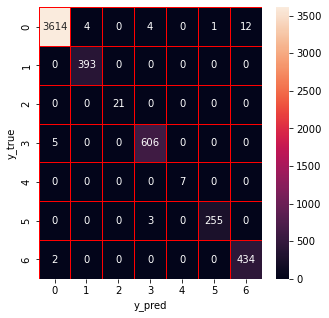

In [38]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [39]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

[00:38:47] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:49] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:50] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:53] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation

[00:39:33] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 0.9966424174594292
Precision of XGBoost: 0.9966716540313325
Recall of XGBoost: 0.9966424174594292
F1-score of XGBoost: 0.9966477200642893
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3635
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        21
           3       0.99      1.00      1.00       611
           4       1.00      1.00      1.00         7
           5       1.00      0.99      1.00       258
           6       0.99      1.00      0.99       436

    accuracy                           1.00      5361
   macro avg       1.00      1.00      1.00      5361
weighted 

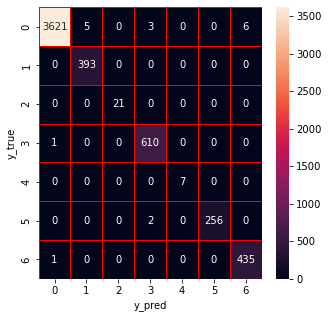

In [40]:
xg = xgb.XGBClassifier(learning_rate= 0.7340229699980686, n_estimators = 70, max_depth = 14)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [41]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with Sequential Model-based Algorithm Configuration (SMAC)

In [43]:
from skopt import forest_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer, Categorical

# space = {
#     'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
#     'max_depth': hp.quniform('max_depth', 4, 100, 1),
#     'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
# }

space = [
    Integer(10, 100, name='n_estimators'),
    Integer(4, 100, name='max_depth'),
    Real(0.01, 0.9, name='learning_rate')
]

@use_named_args(space)
def objective(**params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),
    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return -score

result = forest_minimize(objective, space, n_calls=50)

[00:40:55] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:58] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:41:00] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:41:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation

          fun: -0.9973885469128894
    func_vals: array([-0.99701548, -0.99645589, -0.99645589, -0.99664242, -0.99664242,
       -0.99682895, -0.99626935, -0.99701548, -0.99701548, -0.99701548,
       -0.99682895, -0.99682895, -0.99682895, -0.99664242, -0.99608282,
       -0.99515016, -0.99608282, -0.99682895, -0.99552322, -0.99682895,
       -0.99626935, -0.99179258, -0.99141951, -0.99720201, -0.99738855,
       -0.99608282, -0.99645589, -0.99589629, -0.99533669, -0.99328483,
       -0.99645589, -0.99645589, -0.99664242, -0.99552322, -0.98936766,
       -0.98843499, -0.99328483, -0.99682895, -0.99664242, -0.99216564,
       -0.99179258, -0.99552322, -0.99701548, -0.97966797, -0.99384443,
       -0.98880806, -0.99440403, -0.99664242, -0.99403096, -0.98283902])
       models: [ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_state=616535114), ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_state=616535114), ExtraTr

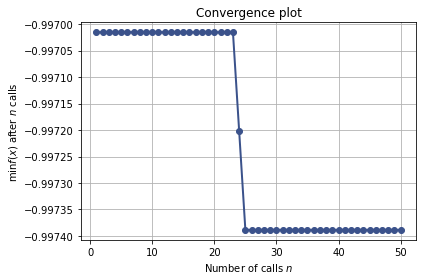

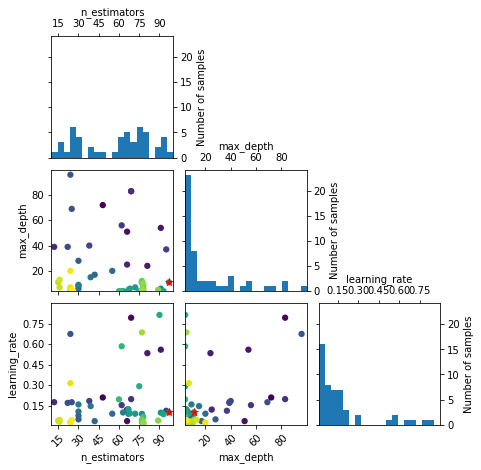

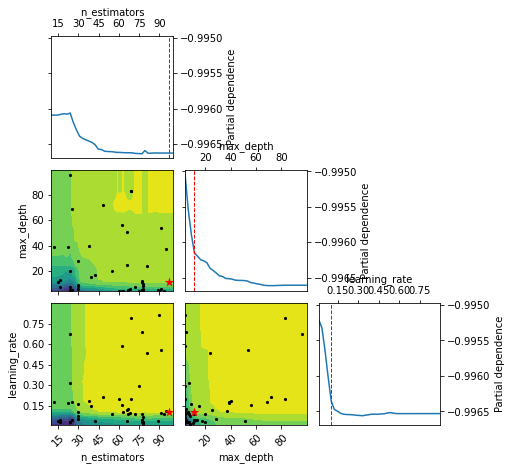

In [44]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)
plot_evaluations(result)
plot_objective(result)
plt.show()

In [47]:
print("""Best parameters:
- n_estimators={}
- max_depth={}
- learning_rate={}""".format(result.x[0], result.x[1], result.x[2]))

Best parameters:
- n_estimators=97
- max_depth=11
- learning_rate=0.10160073526075056


[00:57:00] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 0.9973885469128894
Precision of XGBoost: 0.9973991664535631
Recall of XGBoost: 0.9973885469128894
F1-score of XGBoost: 0.9973905677915479
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3635
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        21
           3       0.99      1.00      0.99       611
           4       1.00      1.00      1.00         7
           5       1.00      0.99      1.00       258
           6       0.99      1.00      0.99       436

    accuracy                           1.00      5361
   macro avg       1.00      1.00      1.00      5361
weighted 

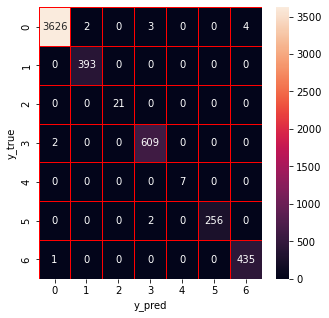

In [48]:
xg = xgb.XGBClassifier(learning_rate= result.x[2], n_estimators = result.x[0], max_depth = result.x[1])
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Apply RF

Accuracy of RF: 0.995709755642604
Precision of RF: 0.9957315288833685
Recall of RF: 0.995709755642604
F1-score of RF: 0.9957149011440201
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3638
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00       613
           4       1.00      1.00      1.00         7
           5       0.99      0.99      0.99       252
           6       0.98      0.99      0.99       436

    accuracy                           1.00      5361
   macro avg       0.99      1.00      1.00      5361
weighted avg       1.00      1.00      1.00      5361



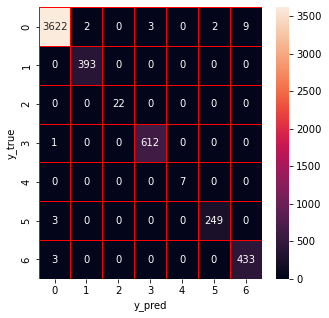

In [42]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [43]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [01:29<00:00,  4.49s/trial, best loss: -0.996082820369334]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 26.0, 'max_features': 7.0, 'min_samples_leaf': 1.0, 'min_samples_split': 7.0, 'n_estimators': 180.0}


Accuracy of RF: 0.9942174967356836
Precision of RF: 0.9942971921969757
Recall of RF: 0.9942174967356836
F1-score of RF: 0.9942351148815388
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3638
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        22
           3       0.99      1.00      0.99       613
           4       0.88      1.00      0.93         7
           5       0.99      0.98      0.99       252
           6       0.97      1.00      0.98       436

    accuracy                           0.99      5361
   macro avg       0.97      1.00      0.98      5361
weighted avg       0.99      0.99      0.99      5361



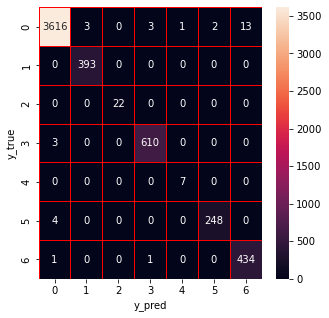

In [44]:
rf_hpo = RandomForestClassifier(n_estimators = 71, min_samples_leaf = 1, max_depth = 46, min_samples_split = 9, max_features = 20, criterion = 'entropy')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [45]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 0.9919791083753031
Precision of DT: 0.9923005659924012
Recall of DT: 0.9919791083753031
F1-score of DT: 0.9920703339148623
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3638
           1       0.98      0.99      0.99       393
           2       1.00      1.00      1.00        22
           3       0.99      1.00      1.00       613
           4       0.64      1.00      0.78         7
           5       0.99      0.98      0.98       252
           6       0.97      0.99      0.98       436

    accuracy                           0.99      5361
   macro avg       0.94      0.99      0.96      5361
weighted avg       0.99      0.99      0.99      5361



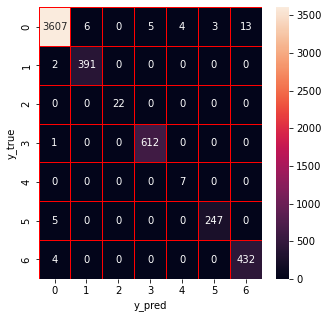

In [46]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [47]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|██████████| 50/50 [00:05<00:00,  9.80trial/s, best loss: -0.995336690915874] 
Decision tree: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 16.0, 'max_features': 15.0, 'min_samples_leaf': 3.0, 'min_samples_split': 9.0}


Accuracy of DT: 0.9923521731020332
Precision of DT: 0.9924666768757934
Recall of DT: 0.9923521731020332
F1-score of DT: 0.992381423406072
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3638
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00        22
           3       0.99      1.00      0.99       613
           4       0.78      1.00      0.88         7
           5       0.99      0.98      0.99       252
           6       0.97      0.98      0.98       436

    accuracy                           0.99      5361
   macro avg       0.96      0.99      0.97      5361
weighted avg       0.99      0.99      0.99      5361



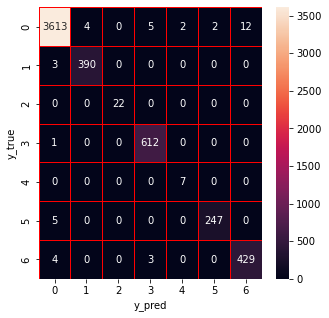

In [48]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 47, min_samples_split = 3, max_features = 19, criterion = 'gini')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [49]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Apply ET

Accuracy of ET: 0.9958962880059691
Precision of ET: 0.9959222288073195
Recall of ET: 0.9958962880059691
F1-score of ET: 0.9959008623297962
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3638
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00       613
           4       1.00      1.00      1.00         7
           5       0.99      0.98      0.99       252
           6       0.98      1.00      0.99       436

    accuracy                           1.00      5361
   macro avg       0.99      1.00      1.00      5361
weighted avg       1.00      1.00      1.00      5361



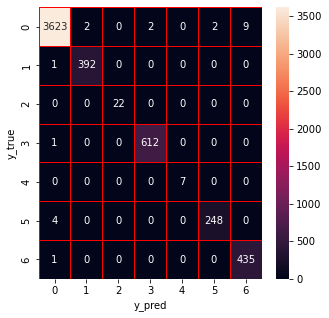

In [50]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [51]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:35<00:00,  1.79s/trial, best loss: -0.9962693527326991]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 33.0, 'max_features': 12.0, 'min_samples_leaf': 1.0, 'min_samples_split': 4.0, 'n_estimators': 147.0}


Accuracy of ET: 0.9964558850960642
Precision of ET: 0.9964868997451385
Recall of ET: 0.9964558850960642
F1-score of ET: 0.9964628183688459
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3638
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00       613
           4       1.00      1.00      1.00         7
           5       0.99      1.00      0.99       252
           6       0.98      1.00      0.99       436

    accuracy                           1.00      5361
   macro avg       0.99      1.00      1.00      5361
weighted avg       1.00      1.00      1.00      5361



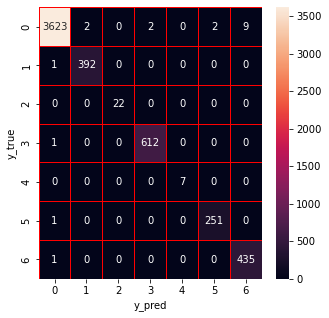

In [52]:
et_hpo = ExtraTreesClassifier(n_estimators = 53, min_samples_leaf = 1, max_depth = 31, min_samples_split = 5, max_features = 20, criterion = 'entropy')
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [53]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply stacking

In [54]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,3,3,3,3
1,5,5,5,5
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [55]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [56]:
dt_train.shape

(23326, 1)

In [57]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

[16:27:41] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of Stacking: 0.9958962880059691
Precision of Stacking: 0.9959383301502173
Recall of Stacking: 0.9958962880059691
F1-score of Stacking: 0.9959054543037243
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3638
           1       1.00      1.00      1.00       393
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00       613
           4       1.00      1.00      1.00         7
           5       0.99      0.99      0.99       252
           6       0.98      1.00      0.99       436

    accuracy                           1.00      5361
   macro avg       0.99      1.00      1.00      5361
weigh

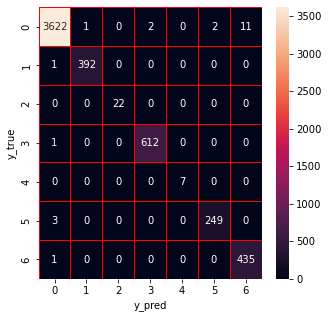

In [58]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [59]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

[16:27:45] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:27:45] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:27:46] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:27:47] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation

[16:27:58] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 0.9958962880059691
Precision of XGBoost: 0.9959194463014738
Recall of XGBoost: 0.9958962880059691
F1-score of XGBoost: 0.9959006972648267
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3638
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00       613
           4       1.00      1.00      1.00         7
           5       0.99      0.99      0.99       252
           6       0.98      1.00      0.99       436

    accuracy                           1.00      5361
   macro avg       0.99      1.00      1.00      5361
weighted 

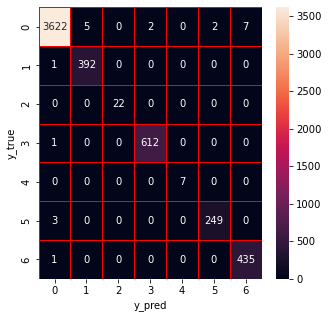

In [60]:
xg = xgb.XGBClassifier(learning_rate= 0.19229249758051492, n_estimators = 30, max_depth = 36)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly-based IDS

### Generate the port-scan datasets for unknown attack detection

In [61]:
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [62]:
df.Label.value_counts()

0    18188
3     3066
6     2180
1     1966
5     1258
2      110
4       36
Name: Label, dtype: int64

In [63]:
df1 = df[df['Label'] != 5]
df1['Label'][df1['Label'] > 0] = 1
df1.to_csv('./data/CICIDS2017_sample_km_without_portscan.csv',index=0)

In [64]:
df2 = df[df['Label'] == 5]
df2['Label'][df2['Label'] == 5] = 1
df2.to_csv('./data/CICIDS2017_sample_km_portscan.csv',index=0)

### Read the generated datasets for unknown attack detection

In [65]:
df1 = pd.read_csv('./data/CICIDS2017_sample_km_without_portscan.csv')
df2 = pd.read_csv('./data/CICIDS2017_sample_km_portscan.csv')

In [66]:
features = df1.drop(['Label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [67]:
df1.Label.value_counts()

0    18188
1     7358
Name: Label, dtype: int64

In [68]:
df2.Label.value_counts()

1    1258
Name: Label, dtype: int64

In [69]:
df2p=df1[df1['Label']==0]
df2pp=df2p.sample(n=None, frac=1255/18225, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [70]:
df2.Label.value_counts()

1    1258
0    1252
Name: Label, dtype: int64

In [71]:
df = df1.append(df2)

In [72]:
X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
pd.Series(y).value_counts()

0    19440
1     8616
dtype: int64

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [75]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [76]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [77]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [78]:
X_fs = df[fs].values

In [79]:
X_fs.shape

(28055, 50)

In [80]:
X_fs

array([[-0.34612159, -0.51326791, -0.44364535, ..., -0.11333586,
        -0.13353417, -0.05349902],
       [-0.3443274 , -0.51326791, -0.44364535, ..., -0.11333586,
        -0.13353417, -0.05349902],
       [-0.3443274 , -0.51326791, -0.44364535, ..., -0.11333586,
        -0.13353417, -0.05349902],
       ...,
       [-0.36859622, -0.20454057, -0.32295149, ..., -0.11333586,
        -0.13353417, -0.05349902],
       [-0.3561313 ,  0.63721854,  0.36583358, ..., -0.11333586,
        -0.13353417,  0.00459227],
       [ 2.7318634 , -0.53347551, -0.44364535, ..., -0.11333586,
        -0.13353417, -0.05349902]])

#### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [81]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [82]:
X_fss = fcbf.fit_transform(X_fs,y)

In [83]:
X_fss.shape

(28055, 20)

In [84]:
X_fss

array([[-0.34612159, -0.53319222, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.41947688],
       [-0.3443274 , -0.54906516, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.41947688],
       [-0.3443274 , -0.55544206, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.41947688],
       ...,
       [-0.36859622, -0.56375976, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.32403604],
       [-0.3561313 ,  0.00413109, -0.33807808, ..., -0.41021078,
        -0.27174505,  0.36453998],
       [ 2.7318634 , -0.53929186, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.42271216]])

####  kernel principal component analysis (KPCA)

In [123]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 10, kernel = 'rbf')
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

### Train-test split after feature selection

In [86]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

### Solve class-imbalance by SMOTE

In [87]:
pd.Series(y_train).value_counts()

0    18225
1     7320
dtype: int64

In [88]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={1:18225})
X_train, y_train = smote.fit_sample(X_train, y_train)

In [89]:
pd.Series(y_train).value_counts()

1    18225
0    18225
dtype: int64

In [90]:
pd.Series(y_test).value_counts()

1    1255
0    1255
dtype: int64

### Apply the cluster labeling (CL) k-means method

In [91]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics

In [124]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

In [94]:
CL_kmeans(X_train, X_test, y_train, y_test, 8)

              precision    recall  f1-score   support

           0       0.58      0.69      0.63      1255
           1       0.62      0.51      0.56      1255

    accuracy                           0.60      2510
   macro avg       0.60      0.60      0.60      2510
weighted avg       0.60      0.60      0.60      2510

0.5984063745019921
[[864 391]
 [617 638]]


### Hyperparameter optimization of CL-k-means
Tune "k"

In [120]:
#Hyperparameter optimization by BO-GP
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn import metrics

space  = [Integer(2, 50, name='n_clusters')]
@use_named_args(space)
def objective(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    cm=metrics.accuracy_score(y_test,result2)
    print(str(n)+" "+str(cm))
    return (1-cm)
from skopt import gp_minimize
import time
t1=time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
t2=time.time()
print(t2-t1)
print("Best score=%.4f" % (1-res_gp.fun))
print("""Best parameters: n_clusters=%d""" % (res_gp.x[0]))

30 0.6972111553784861
43 0.7127490039840637
43 0.399203187250996
43 0.47051792828685257
32 0.653784860557769
20 0.34860557768924305
16 0.9195219123505977
5 0.4370517928286853
15 0.6729083665338645
25 0.7063745019920319
2 0.47808764940239046
50 0.4199203187250996


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2 0.47768924302788845


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


50 0.39282868525896414
17 0.42828685258964144


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2 0.47768924302788845


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2 0.47768924302788845


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


16 0.6992031872509961


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


16 0.3737051792828685


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


50 0.6250996015936255
9.127083539962769
Best score=0.9195
Best parameters: n_clusters=16


In [121]:
#Hyperparameter optimization by BO-TPE
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def objective(params):
    params = {
        'n_clusters': int(params['n_clusters']), 
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    score=metrics.accuracy_score(y_test,result2)
    print(str(params['n_clusters'])+" "+str(score))
    return {'loss':1-score, 'status': STATUS_OK }
space = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

23 0.34422310756972113
15 0.6685258964143427
46 0.450199203187251
15 0.4896414342629482
29 0.6824701195219124
36 0.3888446215139442
22 0.35776892430278884
25 0.34860557768924305
42 0.41832669322709165
27 0.47051792828685257
26 0.39402390438247015
25 0.6824701195219124
33 0.3848605577689243
19 0.7191235059760956
6 0.5824701195219123
21 0.6697211155378486
24 0.451394422310757
37 0.4681274900398406
14 0.47250996015936253
21 0.8434262948207172
100%|███████████████████████████████████████████████| 20/20 [00:06<00:00,  2.87trial/s, best loss: 0.15657370517928282]
Random Forest: Hyperopt estimated optimum {'n_clusters': 21.0}


In [122]:
CL_kmeans(X_train, X_test, y_train, y_test, 16)

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1255
           1       0.91      0.99      0.95      1255

    accuracy                           0.95      2510
   macro avg       0.95      0.95      0.94      2510
weighted avg       0.95      0.95      0.94      2510

0.9450199203187251
[[1127  128]
 [  10 1245]]


### Apply the CL-k-means model with biased classifiers

In [125]:
# needs to work on the entire dataset to generate sufficient training samples for biased classifiers
def Anomaly_IDS(X_train, X_test, y_train, y_test,n,b=100):
    # CL-kmeans
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y2,result2)
    print(str(acc))
    print(cm)
    
    #Biased classifier construction
    count=0
    print(len(y))
    a=np.zeros(n)
    b=np.zeros(n)
    FNL=[]
    FPL=[]
    for v in range(0,n):
        al=[]
        bl=[]
        for i in range(0,len(y)):   
            if result[i]==v:        
                if y[i]==1:        #label 1
                    a[v]=a[v]+1
                    al.append(i)
                else:             #label 0
                    b[v]=b[v]+1
                    bl.append(i)
        if a[v]<=b[v]:
            FNL.extend(al)
        else:
            FPL.extend(bl)
        #print(str(v)+"="+str(a[v]/(a[v]+b[v])))
        
    dffp=df.iloc[FPL, :]
    dffn=df.iloc[FNL, :]
    dfva0=df[df['Label']==0]
    dfva1=df[df['Label']==1]
    
    dffpp=dfva1.sample(n=None, frac=len(FPL)/dfva1.shape[0], replace=False, weights=None, random_state=None, axis=0)
    dffnp=dfva0.sample(n=None, frac=len(FNL)/dfva0.shape[0], replace=False, weights=None, random_state=None, axis=0)
    
    dffp_f=pd.concat([dffp, dffpp])
    dffn_f=pd.concat([dffn, dffnp])
    
    Xp = dffp_f.drop(['Label'],axis=1)  
    yp = dffp_f.iloc[:, -1].values.reshape(-1,1)
    yp=np.ravel(yp)

    Xn = dffn_f.drop(['Label'],axis=1)  
    yn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    yn=np.ravel(yn)
    
    rfp = RandomForestClassifier(random_state = 0)
    rfp.fit(Xp,yp)
    rfn = RandomForestClassifier(random_state = 0)
    rfn.fit(Xn,yn)

    dffnn_f=pd.concat([dffn, dffnp])
    
    Xnn = dffn_f.drop(['Label'],axis=1)  
    ynn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    ynn=np.ravel(ynn)

    rfnn = RandomForestClassifier(random_state = 0)
    rfnn.fit(Xnn,ynn)

    X2p = df2.drop(['Label'],axis=1) 
    y2p = df2.iloc[:, -1].values.reshape(-1,1)
    y2p=np.ravel(y2p)

    result2 = km_cluster.predict(X2p)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y)):
            if result[i]==v:
                if y[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    l1=[]
    l0=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y2p)):
        if result2[v] in list1:
            result2[v]=0
            l0.append(v)
        elif result2[v] in list2:
            result2[v]=1
            l1.append(v)
        else:
            print("-1")
    print(classification_report(y2p, result2))
    cm=confusion_matrix(y2p,result2)
    print(cm)

More details are in the paper